# Image Classification Improved model
13May2023 Li-Hsin Liang

In [1]:
# Import relevant library
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
# Access data
import pathlib
data_dir_path = "data/yoga_poses"
data_dir = pathlib.Path(data_dir_path)

In [3]:
# Count the data volume
# '*/*.jpg' this is to check all the file even in the sub-folder with .jpg at the end.
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

630


Found 630 files belonging to 5 classes.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-05-23 00:27:24.545809: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


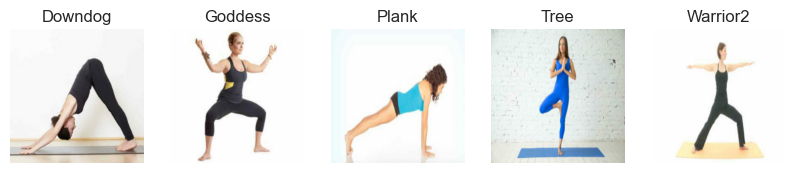

In [4]:
# Display training dataset sample, including 5 yoga poses
train_ds = tf.keras.utils.image_dataset_from_directory(data_dir)
class_names  = ['Downdog', 'Goddess', 'Plank', 'Tree', 'Warrior2']

plt.figure(figsize=(10,8))
for i in range(len(class_names)):
    filtered_ds = train_ds.filter(lambda x, l: tf.math.equal(l[0], i))
    for image, label in filtered_ds.take(1):
        ax = plt.subplot(1, 5, i+1)
        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title(class_names[label.numpy()[0]])
        plt.axis('off')

### Build model

In [5]:
batch_size = 64
img_height = 180
img_width = 180

# Data split
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

class_names = train_ds.class_names
num_classes = len(class_names)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(512).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Data augmentation
data_augmentation_layer = keras.Sequential(
    [
        layers.Resizing(img_height, img_width),
        layers.RandomFlip("horizontal"),
        layers.RandomBrightness((-0.25, 0.25)),
        layers.RandomContrast((0.25, 0.25)),
        layers.RandomTranslation((-0.15, 0.15), (-0.15, 0.15), fill_mode='constant'),
        layers.RandomRotation((-0.025, 0.025), fill_mode='constant'),
        layers.RandomZoom((0, 0.25), fill_mode='constant'),
    ]
)
augmented_ds = train_ds.map(lambda x, y: (data_augmentation_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_ds))

Found 630 files belonging to 5 classes.
Using 504 files for training.
Found 630 files belonging to 5 classes.
Using 126 files for validation.


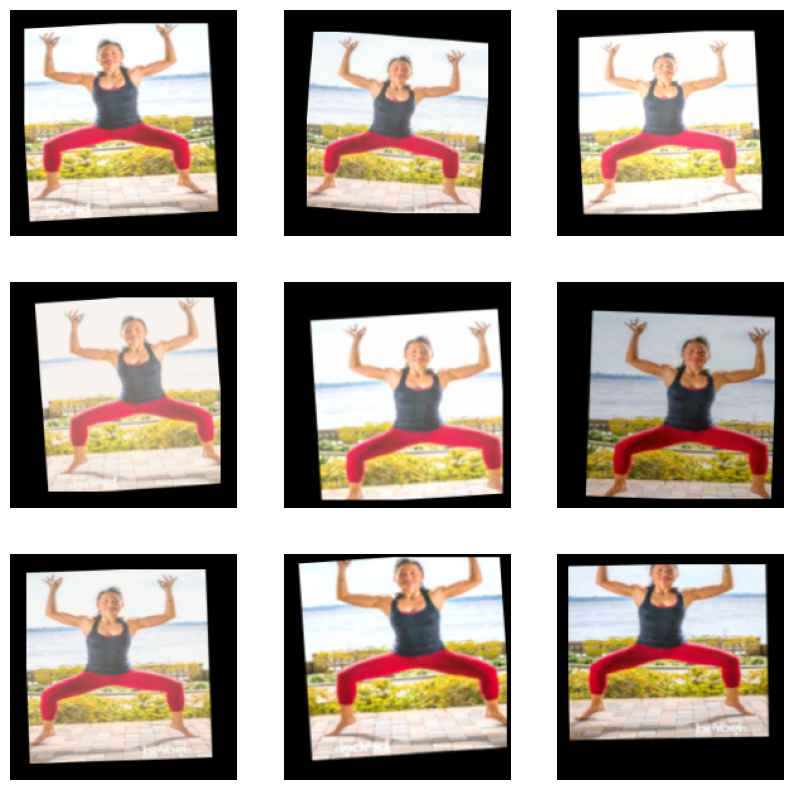

In [ ]:
with tf.device('/GPU:0'):
    plt.figure(figsize=(10, 10))
    for images, _ in train_ds.take(1):
        for i in range(9):
            augmented_images = data_augmentation_layer(images)
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(augmented_images[0].numpy().astype("uint8"))
            plt.axis("off")

In [ ]:
model = Sequential([
    # Data normalisation
    layers.InputLayer((img_height, img_width, 3)),
    layers.Rescaling(1./255),
    # 1st convolutional block
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    # 2nd convolutional block
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    # 3nd convolutional block
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    # 4th convolutional block
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    # 5th convolutional block
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    # 6th convolutional block
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    # Add dropout
    layers.Dropout(0.3),
    # Fully-connected layer
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

# Training model with 100 epochs
epochs = 100
history = model.fit(
    augmented_ds,
    validation_data=val_ds,
    epochs=epochs
)

8/8 [==============================] - 5s 503ms/step - loss: 1.5688 - accuracy: 0.2877 - val_loss: 1.5762 - val_accuracy: 0.2778
Epoch 2/100
8/8 [==============================] - 5s 599ms/step - loss: 1.5701 - accuracy: 0.2341 - val_loss: 1.5531 - val_accuracy: 0.2778
Epoch 3/100
8/8 [==============================] - 4s 454ms/step - loss: 1.5660 - accuracy: 0.2659 - val_loss: 1.5594 - val_accuracy: 0.2778
Epoch 4/100
8/8 [==============================] - 4s 481ms/step - loss: 1.5558 - accuracy: 0.2897 - val_loss: 1.5542 - val_accuracy: 0.2778
Epoch 5/100
8/8 [==============================] - 4s 459ms/step - loss: 1.5549 - accuracy: 0.2956 - val_loss: 1.5480 - val_accuracy: 0.2778
Epoch 6/100
8/8 [==============================] - 4s 425ms/step - loss: 1.5467 - accuracy: 0.2817 - val_loss: 1.5415 - val_accuracy: 0.2778
Epoch 7/100
8/8 [==============================] - 4s 426ms/step - loss: 1.5264 - accuracy: 0.3294 - val_loss: 1.5302 - val_accuracy: 0.3571
Epoch 8/100
8/8 [========

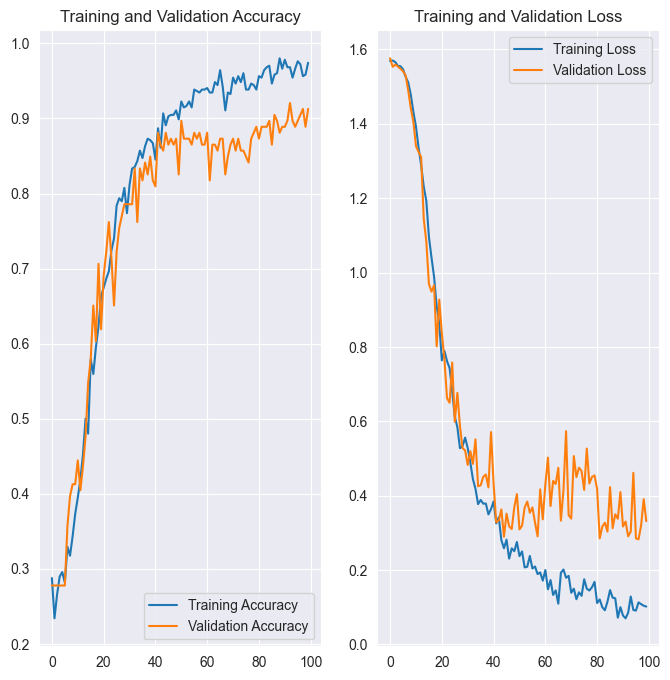

In [8]:
# data visualisation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)       

# Test the model

the improved model predict the following poses **correct**

In [11]:
downdog_path = "data/sample/downdog/IMG_0001.jpeg"
plank_path = "data/sample/plank/IMG_0002.jpeg"
tree_path = "data/sample/tree/IMG_9996.jpeg"
warrior2_path = "data/sample/warrior2/IMG_0020.jpeg"
goddess_path = "data/sample/goddess/IMG_9992.jpeg"
wrong_data_path = "data/sample/wrong_data/IMG_0065.jpeg"

img = tf.keras.utils.load_img(
    tree_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 282ms/step
This image most likely belongs to tree with a 60.02 percent confidence.


In [12]:
#perdiction for each poses
print(class_names)
for num in predictions:
    print(num)

['downdog', 'goddess', 'plank', 'tree', 'warrior2']
[-1.6400523   0.54382354  0.23997892  1.6384072  -1.42698   ]


### Confusion Matrix
to see what pose get confusion with other poses

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def get_actual_predicted_labels(dataset):
    """
      Create a list of actual ground truth values and the predictions from the model.

      Args:
        dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

      Return:
        Ground truth and predicted values for a particular dataset.
    """
    actual = [labels for _, labels in dataset.unbatch()]
    predicted = model.predict(dataset)

    actual = tf.stack(actual, axis=0)
    predicted = tf.concat(predicted, axis=0)
    predicted = tf.argmax(predicted, axis=1)

    return actual, predicted

def plot_confusion_matrix(actual, predicted, labels, ds_type):
    cm = tf.math.confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, annot=True, fmt='g')
    sns.set(rc={'figure.figsize':(8, 8)})
    sns.set(font_scale=1.4)
    ax.set_title('Confusion matrix of action recognition for ' + ds_type)
    ax.set_xlabel('Predicted Action')
    ax.set_ylabel('Actual Action')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

# Print heatmaps
actual, predicted = get_actual_predicted_labels(train_ds)
plot_confusion_matrix(actual, predicted, class_names, 'training')

# Save model

In [10]:
model.save('experiment/improved_model')

INFO:tensorflow:Assets written to: experiment/improved_model/assets


INFO:tensorflow:Assets written to: experiment/improved_model/assets
